Hui-Kang Tong admin, [2 Apr 2018 at 19:31:29]:
ok we can now automatically generate midi files, convert midi files to wave files (with hk’s mac)

However to create training data, we need many data (audio samples) with the same target/label (note). So these are a few ways to vary it:
- note velocity
- note volume
- noise
- onset timing (one slightly later than the other)
- soundfont (which mean instrument)

So I will write a notebook which
- leave a space for the function to create .mid file with note
- use fluidsynth to convert this .mid file .wav
- call this .mid file, identify onset with our onset function, and splice 4096 entries from it
- leave a space for the training function
- delete the .mid file and .wav file
- repeat

What needs to be considered/written
what kind of model are we using, how do we train such a model, what sort of instructions does the .mid files have

In [1]:
from midiutil.MidiFile import MIDIFile
from itertools import combinations
import os
import subprocess
from time import sleep
import matplotlib.pyplot as plt
import soundfile as sf
import numpy as np
import sounddevice as sd
from itertools import combinations

In [2]:
# Functions for onset detection

def rcoeff_(snippet):
    return np.corrcoef(snippet, np.arange(len(snippet)))[0, 1]

rcoeff = np.vectorize(rcoeff_, signature='(n)->()')

def divide_chunks(signal, intervals, snippet_size):
# yield successive n-sized chunks from l.
    for i in range(0, len(signal) - snippet_size, intervals):
        # looping till the end of the array
        yield signal[i:i + snippet_size]
        
def max_to_one(arr):
    '''Scale the maximum of an array to one'''
    return np.divide(arr, np.max(np.absolute(arr)))

def detect_onset_given_entire_signal(signal, plotting=True):
    '''
    Onset detection function. Could be replaced with a better one.
    Returns two signals, 
    - a short one (fixed at length 4096) for a standard note evaluation algorithm, 
    - a long one (usually 3*4096) for making spectrograms and applying machine learning algorithms like CNN.
    (Why not standardise them, return the longer one instead?)
    Onset detection is carried out every 32 points so we do not have to calculate the r-value of 4096 points at every point.
    '''
#     print(len(signal))
    signal_cs = np.cumsum(np.absolute(signal))
    signal_cs = np.add(signal_cs, np.random.randn(len(signal_cs)))
#     print(len(signal_cs))
    signal_chunk_sum = signal_cs[4096:] - signal_cs[:-4096]
    snippets = np.array(list(divide_chunks(signal_chunk_sum, 32, 4096)))
    signal_rcoeff = rcoeff(snippets)

#     print("loc")
#     print(signal_rcoeff)
#     print(np.where(signal_rcoeff>0.8)[0][0])
    location = np.where(signal_rcoeff>0.8)[0][0]
    start_pt, end_pt = location*32+7168, location*32+7168+4096
    map_start_pt = location*32+7168-3*4096
    if map_start_pt < 0:
        map_start_pt = 0
    
    if plotting:
        plt.plot(np.arange(4096, len(signal)), max_to_one(signal_chunk_sum))
        plt.plot(np.arange(4096*2, len(signal), 32), signal_rcoeff)
        plt.axvline(x=start_pt,color="red")
        plt.axvline(x=end_pt,color="red")
        plt.show()
        
    return signal[start_pt:end_pt], signal[map_start_pt:end_pt]

In [4]:
def generate_midi_file(com,midi_instructions):
    # generate and save midifile
    mf = MIDIFile(len(com)+1)  # don't know why need one extra
    
    track, channel, time, duration, volume = midi_instructions
    for i in range(len(com)):
        mf.addNote(track, channel, com[i], time, duration, volume)

    code = []
    for num in com:
        code.append(num)
    while len(code) < 4:
        code.append("x")

    filename = "C{}_{}_{}_{}_{}".format(4, code[0], code[1], code[2], code[3])
    # first argument not necessary - convention to be updated
    print(filename)
    with open("midifile_sch/{}.mid".format(filename), "wb") as outf:
        mf.writeFile(outf)
        
    return filename

In [5]:
def convert_midi_to_signal(filename):
    '''
    Given filename, create soundfile.
    It uses fluidsynth to convert the midifile from the directory into a soundfile in another directory.
    Installation of fluidsynth is necessary to run this.
    https://github.com/FluidSynth/fluidsynth/wiki/BuildingWithCMake
    returns mono signal - could we use stereo information for evaluation someday?
    '''
    soundfont_dir = "~/soundfonts/GeneralUser\ GS\ v1.471.sf2"
    subprocess.run("fluidsynth -F soundfile_sch/{}.wav {} midifile_sch/{}.mid"
                   .format(filename,soundfont_dir,filename),shell=True)
    sleep(1)
    audio,sr = sf.read("soundfile_sch/{}.wav".format(filename))
    if type(audio[0]) != float or type(audio[0]) != int: 
        # if stereo (expected)
        signal = audio[:,0]  
    else:    
        # if mono (but I have yet to try this out)
        signal = audio[:]
    assert (signal[0] != float or signal[0] != int)
    return signal

In [6]:
import librosa
import librosa.display

# Functions for note evaluation

def plot_spectrum(signal_to_ayse):
    freq_domain = np.fft.fft(signal_to_ayse)
    plt.figure(figsize=(12,2))
    plt.plot(np.linspace(0, 250*44100/4096., 250, endpoint=True), np.absolute(freq_domain[:250]))
    plt.xlabel("frequency (Hz)")
    plt.title("Spectrum of signal analysed")
    plt.axvline(x = 261.625565, color="red")
    plt.axvline(x = 261.625565*2., color="red")
    plt.show()

def plot_spectrograms(signal_to_ayse, signal_to_map):
    '''
    Plots
    - a spectrum from signal_to_ayse 
    - three spectrograms from signal_to_map
    You can customise them.
    '''
    plot_spectrum(signal_to_ayse)
    
    plt.figure(figsize=(12,9))
    
    # https://librosa.github.io/librosa/generated/librosa.display.specshow.html
    plt.subplot(131)
    D = librosa.stft(signal_to_map)
    librosa.display.specshow(librosa.amplitude_to_db(librosa.magphase(D)[0], ref=np.max),
                                                     y_axis='linear', x_axis='time')
    plt.title('Power spectrogram (linear)')
    
    plt.subplot(132)
    D = librosa.stft(signal_to_map)
    librosa.display.specshow(librosa.amplitude_to_db(librosa.magphase(D)[0], ref=np.max),
                                                     y_axis='log', x_axis='time')
    plt.title('Power spectrogram (log)')
    
    # https://librosa.github.io/librosa/generated/librosa.core.cqt.html
    plt.subplot(133)
    CQT = librosa.amplitude_to_db(np.absolute(librosa.cqt(signal_to_map, sr=44100)), 
                                  ref=np.max)
    librosa.display.specshow(CQT, y_axis='cqt_note')
    plt.title('Constant-Q power spectrogram (note)')
    
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

In [7]:
def test_function_accuracy_single(note_detection_function_to_test,
                                  com, midi_instructions,
                                  plotting=True, deleting=True):
    '''
    Make plotting False if you do not want see the plots.
    Make deleting False if you do not want to delete the file after testing
    '''
    
    # generate midi file
    filename = generate_midi_file(com,midi_instructions)
    
    # convert midi file to signal
    signal = convert_midi_to_signal(filename)
    
    if plotting:
        sd.play(signal, 44100)
        sleep(1)
        plt.figure(figsize=(12,2))
        plt.plot(signal)
        # plt.show()
    
    # onset detection
    signal_to_ayse, signal_to_map = detect_onset_given_entire_signal(signal, plotting)
    

    if plotting:
        plt.figure(figsize=(12,2))
        plt.plot(signal_to_map)
        plt.title("Signal analysed")
        plt.axvline(x=len(signal_to_map)-4096, color="red")
        plt.axvline(x=len(signal_to_map), color="red")
        plt.show()
    
        plot_spectrograms(signal_to_ayse, signal_to_map)
    
    # note detection
    # given a 4096 length snippet find out the what are notes
    # probably use this to evaluate the accuracy
    # make this train also

    result = note_detection_function_to_test(signal_to_ayse)
    print("--results--")
    print(com)
    print(result)
    print("===========")
    
    sleep(1)
    if deleting:
        # remove midifile
        subprocess.run("rm midifile_sch/{}.wav".format(filename),shell=True) 
        # remove soundfile
        subprocess.run("rm soundfile_sch/{}.wav".format(filename),shell=True)
        
    return result

In [8]:
def test_function_accuracy(note_detection_function_to_test, plotting = True, deleting = True):
    
    scales = range(5,6)  # C4 (middle C) to C5
    no_of_notes = range(2, 5)  # 2 notes to 4 notes

    channel = 0
    time = 0.5
    duration = 2
    tempo = 100
    volume = 100
    track = 1
    
    # can loop in other ways or random
    comb_list = []
    for scale in scales:
        for no_ in no_of_notes:

            pitch = range(12*(scale), 12*(scale+1))
            comb = [list(x) for x in combinations(pitch, no_)]
            comb_list += comb
            
    midi_instructions = track, channel, time, duration, volume 

    stats = []
    for com in np.random.permutation(comb_list):
        result = test_function_accuracy_single(note_detection_function_to_test,
                                               com, midi_instructions,
                                               plotting = plotting, 
                                               deleting = deleting)
        notes_present = len(com)
        notes_detected = len(result)
        present_and_detected = sum(x in com for x in result)
        not_present_but_detected = sum(x not in com for x in result)
        present_but_not_detected = sum(x not in result for x in com)
        stats.append([notes_present,
                     notes_detected,
                     present_and_detected,
                     not_present_but_detected,
                     present_but_not_detected])
        print(stats[-1])
        # print some cumulative statistics here

C4_61_62_65_70


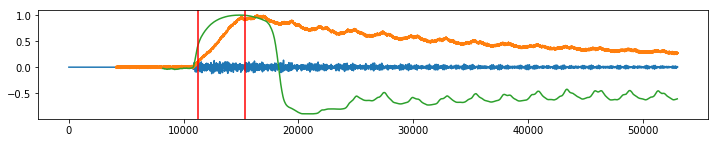

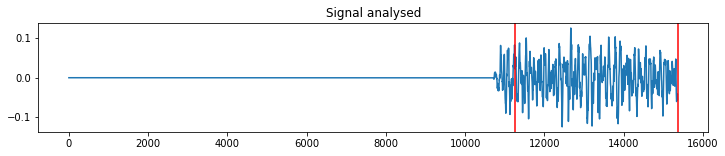

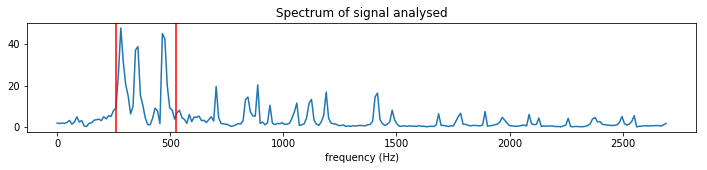

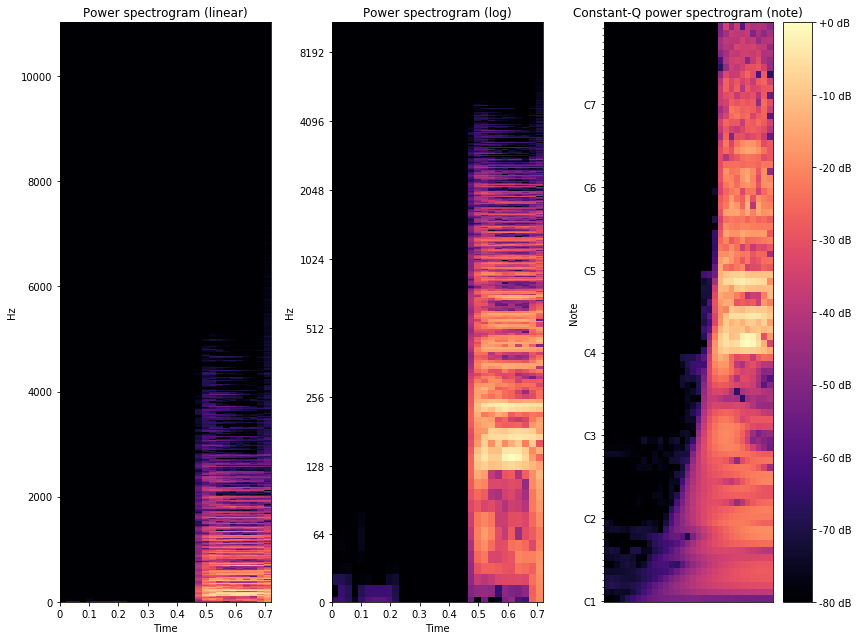

--results--
[61, 62, 65, 70]
[]
[4, 0, 0, 0, 4]
C4_63_64_66_70


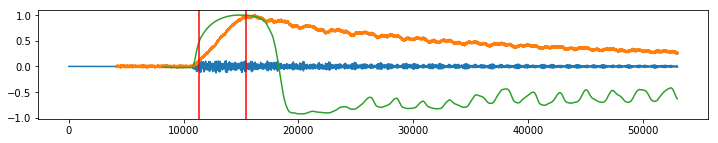

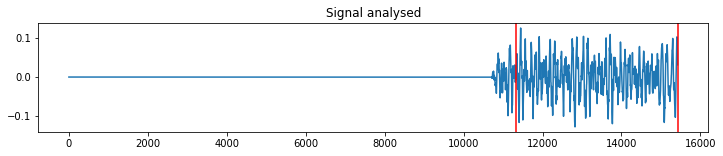

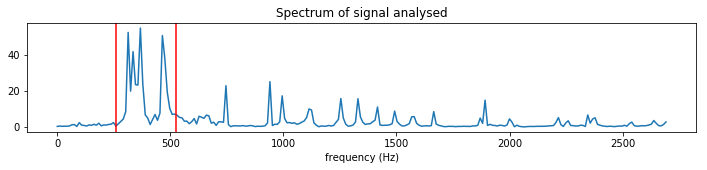

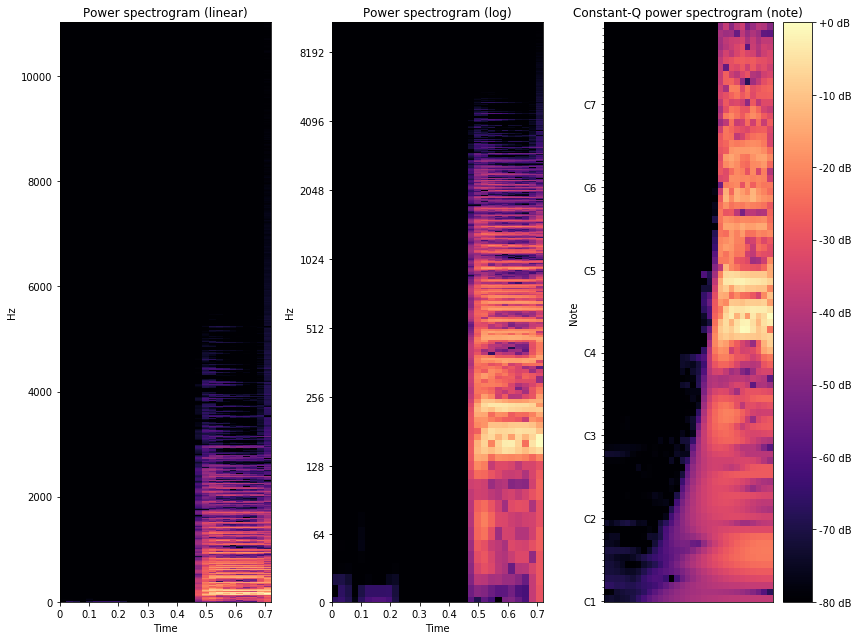

--results--
[63, 64, 66, 70]
[63, 66]
[4, 2, 2, 0, 2]
C4_64_68_70_x


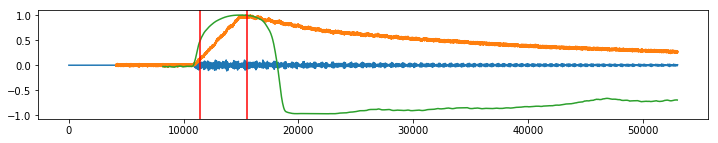

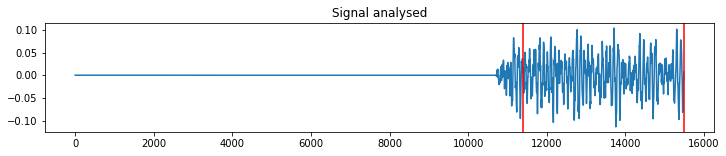

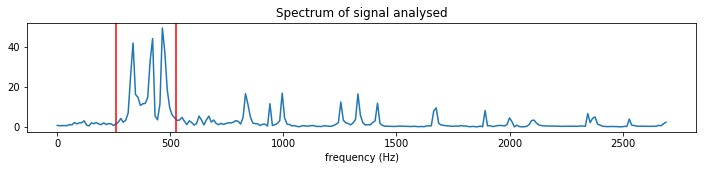

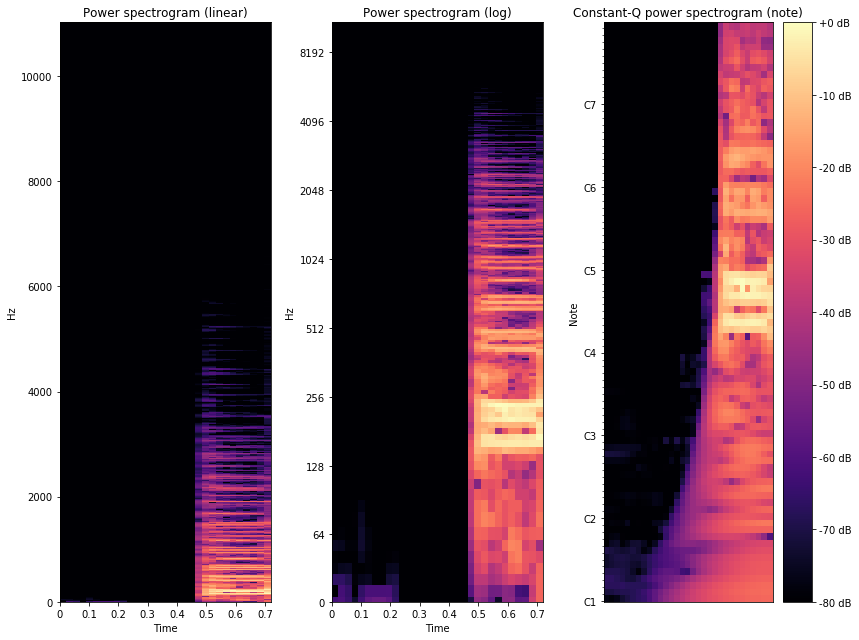

--results--
[64, 68, 70]
[64, 68, 70]
[3, 3, 3, 0, 0]
C4_61_62_67_68


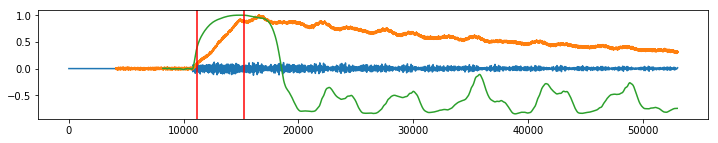

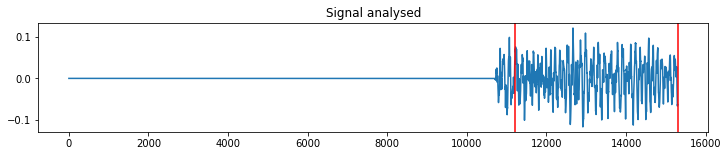

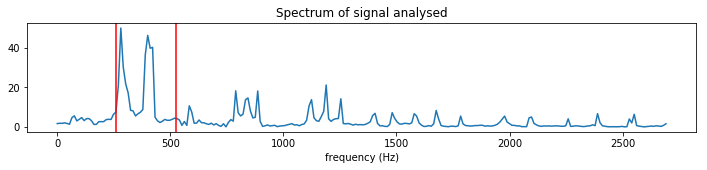

KeyboardInterrupt: 

In [10]:
# # Do not uncomment this, this is a helper notebook not supposed to run this.
# if __name__ == '__main__':
#     test_function_accuracy("YOUR FUNCTION HERE, plotting=True, deleting=True)

In [1]:
def cqt_function_return_notesrum(signal_to_ayse):
    '''
    Compute the cqt response over a set of notes.

    Parameters
    ----------
    signal_to_ayse : input array, real
                     4096 entries long

    Output
    ----------
    MIDI numbers
    60 is middle C, which is C4
    
    Todo
    ----
    We should not be generating the kernels every time.
    Actually we could simply multiply with the FFT of the signal.
    So:
    Make it customisable to a random starting note.
    Outsource the precomputation to a function instead - do something like load kernels.
    Do both of these at the same time.
    (but anyway we just want an accurate demo, computation time doesn't seem to be a problem here)
    '''

    length = len(signal_to_ayse)
#     print(length)

    # fast fourier transform
    freq_domain = np.fft.fft(signal_to_ayse)
    
    # defining the 36 notes bins
    bins = 40
    freq_ref_notes = [261.625565 * (2. ** (n / 36. - 5. / 72.)) for n in range(bins)]

    # defining the time kernel
    # different note have different "kernels"
    bell_curves = []
    for note in range(len(freq_ref_notes)):
        # I don't think this is defined properly?
        bell_curve = np.exp(-((np.arange(-1., 1., 2. / length)) * (2. ** (note / 36.))) ** 2.)
        bell_curves.append(bell_curve)

    # multiplying the waveform with the window
    kernels = []
    for note in range(bins):
        # generate cosine/sine wave
        wave = np.exp((np.arange(length) - length / 2.) * -1.j * 2. * np.pi * freq_ref_notes[note] / 44100.)
        # multiplying a window over it
        kernels.append(np.multiply(wave, bell_curves[note]))

    # taking fourier transform for the frequency kernel
    fft_kernels = []
    for note in range(bins):
        fft_kernels.append(np.fft.fft(kernels[note]))
    # all of the above should be run only once
    # but the maximum complexity is only the FFT, it is still not a problem
    # the focus is an MVP anyway
    # we prioritse accuracy here though
    # creating arrays to populate for each one-third-semitone
    cqt_resp_specs = []
    cqt_resp = []

    # populating the arrays
    for note in range(bins):
        cqt_resp_spec = []
        for entry in range(length):
            cqt_resp_spec.append(fft_kernels[note][entry] * freq_domain[entry])
        cqt_resp_specs.append(cqt_resp_spec)
        cqt_resp.append(sum([abs(x) for x in cqt_resp_spec]))

    # finding peaks in the cqt response
    notesrum = cqt_resp  # remove redundant variable please

    return notesrum